# [모듈 0.3]  네이버 영화 리뷰 스크래치

- 김대근님의 [Lab 1-1: Train Hugging Face Transformers on Local Environment](https://github.com/daekeun-ml/sm-huggingface-kornlp/blob/main/lab_1_training/1_local_training.ipynb) 노트북의 대부분 내용을 실행한 내용 입니다.
---

아래 노트북은 다음과 같은 작업을 합니다.
- 1. 환경 설정
- 2. 데이터 셋트 로딩
- 3. Pretrained Model 및 토큰 나이저 로딩
- 4. 훈련 준비
- 5. 훈련 실행
- 6. 추론 및 평가

# 1. 환경 설정

In [1]:
import torch

import os
import json
import sys
import logging

logging.basicConfig(
    level=logging.INFO, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)



# 2. 데이터 셋트 로딩

## 2.1. 라이브러리 정의

In [2]:
from datasets import load_dataset
from transformers import (
    ElectraModel, ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments, set_seed
)
from transformers.trainer_utils import get_last_checkpoint



[{utils.py:157} INFO - NumExpr defaulting to 8 threads.


## 2.2. HuggingFace 에서 다운로드할 내용 정의
- tokenizer_id, model_id 정의
- dataset 정의

In [3]:
tokenizer_id = 'monologg/koelectra-small-v3-discriminator'
model_id = "monologg/koelectra-small-v3-discriminator"

# dataset used
dataset_name = 'nsmc'

## 2.3. HuggingFace 에 정의된 nsmc 데이터 세트 다운로드

In [4]:
train_dataset, test_dataset = load_dataset(dataset_name, split=['train[:1%]', 'test[:1%]'])

[{builder.py:412} WARNING - Using custom data configuration default
[{builder.py:577} WARNING - Reusing dataset nsmc (/home/ec2-user/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
logger.info(f" loaded train_dataset length is: {len(train_dataset)}")
logger.info(f" loaded test_dataset length is: {len(test_dataset)}")
logger.info(train_dataset[0])

[{1823590636.py:1} INFO -  loaded train_dataset length is: 1500
[{1823590636.py:2} INFO -  loaded test_dataset length is: 500
[{1823590636.py:3} INFO - {'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}


In [6]:
print(type(train_dataset))


<class 'datasets.arrow_dataset.Dataset'>


## 2.4. 다운로드한 데이터 세트를 로컬에 저장

In [7]:
train_dir = 'datasets/train'
test_dir = 'datasets/test'
!rm -rf {train_dir} {test_dir}

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True) 

if not os.listdir(train_dir):
    train_dataset.save_to_disk(train_dir)
if not os.listdir(test_dir):
    test_dataset.save_to_disk(test_dir)



# 3. 훈련 준비

## 3.1. Pretrained Model 및 토큰 나이저 다운로드
- ElectraTokenizer 다운로드
- tokenizer 정의
- train, test 데이터 세트 생성
    - BERT 입력 형태로 인코딩

In [8]:
# download tokenizer
tokenizer = ElectraTokenizer.from_pretrained(tokenizer_id)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['document'], padding='max_length', max_length=128, truncation=True)

# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


[{arrow_dataset.py:2567} WARNING - Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-0e27e655f7446c3d.arrow
[{arrow_dataset.py:2567} WARNING - Loading cached processed dataset at /home/ec2-user/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-abf5f1a87c56663f.arrow


## 3.2. 입력 매개 변수 준비

In [9]:
import argparse

def parser_args(train_notebook=False):
    parser = argparse.ArgumentParser()

    # Default Setting
    parser.add_argument("--epochs", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=128)
    parser.add_argument("--warmup_steps", type=int, default=0)
    parser.add_argument("--learning_rate", type=str, default=5e-5)
    parser.add_argument("--disable_tqdm", type=bool, default=False)
    parser.add_argument("--fp16", type=bool, default=True)
    parser.add_argument("--tokenizer_id", type=str, default='monologg/koelectra-small-v3-discriminator')
    parser.add_argument("--model_id", type=str, default='monologg/koelectra-small-v3-discriminator')    

    # SageMaker Container environment
    parser.add_argument("--output_data_dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--model_dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--n_gpus", type=str, default=os.environ["SM_NUM_GPUS"])
    parser.add_argument("--training_dir", type=str, default=os.environ["SM_CHANNEL_TRAIN"])
    parser.add_argument("--test_dir", type=str, default=os.environ["SM_CHANNEL_TEST"])
    parser.add_argument('--chkpt_dir', type=str, default='/opt/ml/checkpoints')     

    if train_notebook:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

## 3.3. 입력 매개 변수 저장

In [10]:
chkpt_dir = 'chkpt'
model_dir = 'model'
output_data_dir = 'data'    
!rm -rf {chkpt_dir} {model_dir} {output_data_dir} 

if os.environ.get('SM_CURRENT_HOST') is None:
    is_sm_container = False

    #src_dir = '/'.join(os.getcwd().split('/')[:-1])
    src_dir = os.getcwd()
    os.environ['SM_MODEL_DIR'] = f'{src_dir}/{model_dir}'
    os.environ['SM_OUTPUT_DATA_DIR'] = f'{src_dir}/{output_data_dir}'
    os.environ['SM_NUM_GPUS'] = str(1)
    os.environ['SM_CHANNEL_TRAIN'] = f'{src_dir}/{train_dir}'
    os.environ['SM_CHANNEL_TEST'] = f'{src_dir}/{test_dir}'

args = parser_args(train_notebook=True) 
args.chkpt_dir = chkpt_dir
logger.info("***** Arguments *****")
logger.info(''.join(f'{k}={v}\n' for k, v in vars(args).items()))

os.makedirs(args.chkpt_dir, exist_ok=True) 
os.makedirs(args.model_dir, exist_ok=True)
os.makedirs(args.output_data_dir, exist_ok=True) 

[{2906475765.py:19} INFO - ***** Arguments *****
[{2906475765.py:20} INFO - epochs=5
seed=42
train_batch_size=32
eval_batch_size=128
warmup_steps=0
learning_rate=5e-05
disable_tqdm=False
fp16=True
tokenizer_id=monologg/koelectra-small-v3-discriminator
model_id=monologg/koelectra-small-v3-discriminator
output_data_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/data
model_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/model
n_gpus=1
training_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/datasets/train
test_dir=/home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/datasets/test
chkpt_dir=chkpt



## 3.4. 훈련에 사용할 부가 정보 준비

레이블 정의 확인

In [11]:
labels = train_dataset.features["label"].names
labels

['negative', 'positive']

num_labels, label2id, id2label 준비

In [12]:
# Prepare model labels - useful in inference API

num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Set seed before initializing model
set_seed(args.seed)


In [13]:
print("label2id: \n",label2id) 
print("id2label: \n",id2label) 

label2id: 
 {'negative': '0', 'positive': '1'}
id2label: 
 {'0': 'negative', '1': 'positive'}


## 3.5. Pre-Trained 모델 다운로드

In [14]:
# Download pytorch model
model = ElectraForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

## 3.6. 훈련 매개변수 정의 

In [15]:
# define training args
training_args = TrainingArguments(
    output_dir=args.chkpt_dir,
    overwrite_output_dir=True if get_last_checkpoint(args.chkpt_dir) is not None else False,
    num_train_epochs=args.epochs,
    per_device_train_batch_size=args.train_batch_size,
    per_device_eval_batch_size=args.eval_batch_size,
    warmup_steps=args.warmup_steps,
    fp16=args.fp16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    disable_tqdm=args.disable_tqdm,
    logging_dir=f"{args.output_data_dir}/logs",
    learning_rate=float(args.learning_rate),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

## 3.7. 모델 평가 함수 정의

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# compute metrics function for binary classification
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

## 3.8. 모델 훈련 Estimator (Trainer) 정의

In [17]:
# create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics    
)

Using amp fp16 backend


# 4. 훈련 실행

In [18]:
%%time
# train model
if get_last_checkpoint(args.chkpt_dir) is not None:
    logger.info("***** Continue Training *****")
    last_checkpoint = get_last_checkpoint(args.chkpt_dir)
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    trainer.train()

The following columns in the training set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 1500
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 235


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.684440,0.582000,0.376119,0.863014,0.240458
2,No log,0.550594,0.766000,0.773694,0.784314,0.763359
3,No log,0.486730,0.786000,0.795411,0.796935,0.793893
4,No log,0.504800,0.768000,0.792115,0.746622,0.843511
5,No log,0.461820,0.798000,0.799205,0.834025,0.767176


The following columns in the evaluation set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 128
Saving model checkpoint to chkpt/checkpoint-47
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Configuration saved in chkpt/checkpoint-47/config.json
Model weights saved in chkpt/checkpoint-47/pytorch_model.bin
tokenizer config file saved in chkpt/checkpoint-47/tokenizer_config.json
Special tokens file saved in chkpt/checkpoint-47/special_tokens_map.json
The following columns in the evaluation set  do

CPU times: user 24.4 s, sys: 1.13 s, total: 25.6 s
Wall time: 25.4 s


# 5. 추론 및 평가

## 5.1. 모델 평가

In [19]:
eval_result = trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 128


## 5.2. 모델 평가 메트릭 확인

In [20]:
# writes eval result to file which can be accessed later in s3 ouput
with open(os.path.join(args.output_data_dir, "eval_results.txt"), "w") as writer:
    print(f"***** Evaluation results *****")
    for key, value in sorted(eval_result.items()):
        writer.write(f"{key} = {value}\n")
        logger.info(f"{key} = {value}\n")

***** Evaluation results *****
[{288003498.py:6} INFO - epoch = 5.0

[{288003498.py:6} INFO - eval_accuracy = 0.798

[{288003498.py:6} INFO - eval_f1 = 0.7992047713717694

[{288003498.py:6} INFO - eval_loss = 0.4618203043937683

[{288003498.py:6} INFO - eval_precision = 0.8340248962655602

[{288003498.py:6} INFO - eval_recall = 0.767175572519084

[{288003498.py:6} INFO - eval_runtime = 0.3834

[{288003498.py:6} INFO - eval_samples_per_second = 1304.205

[{288003498.py:6} INFO - eval_steps_per_second = 10.434



## 5.3. 모델 추론 
- 모델 추론하여 예측값 및 진실값 저장

In [21]:
import numpy as np
results = trainer.predict(test_dataset)
y_true = results.label_ids
y_pred = np.argmax(results.predictions, axis=1)

The following columns in the test set  don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: id, document.
***** Running Prediction *****
  Num examples = 500
  Batch size = 128


## 5.4. 평가 함수 (혼돈 행렬 함수 정의)

In [22]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    import itertools
    import matplotlib.pyplot as plt
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## 5.5. 혼돈 행렬 내용 확인하기

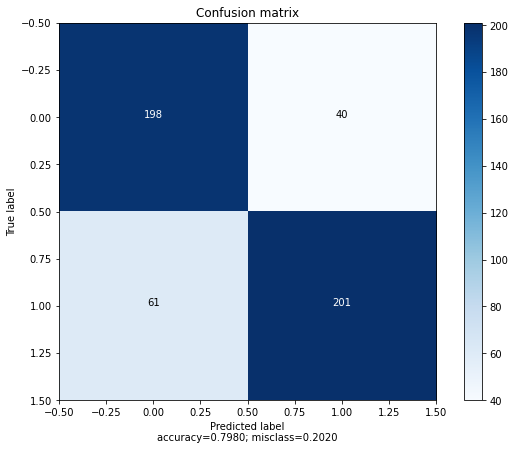

In [23]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cf, normalize=False)

## 5.6. 모델 저장하기

In [24]:
# Remove checkpoints
import shutil
dir_list = os.listdir(args.chkpt_dir)
for d in dir_list:
    shutil.rmtree(os.path.join(args.chkpt_dir, d))
    
trainer.save_model(args.model_dir)

Saving model checkpoint to /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/model
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Configuration saved in /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/model/config.json
Model weights saved in /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/model/pytorch_model.bin
tokenizer config file saved in /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/1_NSMC-Classification/2_WarmingUp/model/tokenizer_config.json
Special tokens file saved in /home/ec2-user/SageMaker/NLP-H

# 6. 커널 리스타팅

- 위의 노트북을 다 실행하고 나면 아래의 그림과 같이 GPU의 메모리를 차지하고 있습니다. (터미널에서 `nvidia-smi` 입력) 
![before-nvidia-smi.png](img/before-nvidia-smi.png)

- 아래 셀을 실행하면 이 노트북의 커널이 리스타트 되고 해제된 메모리를 확인 할 수 있습니다.
![after-nvidia-smi.png](img/after-nvidia-smi.png)

In [25]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}